In [1]:
import sys; sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations

np.random.seed(42)

In [2]:
data = pd.read_csv("./data/data.csv")

print(f"Data shape: {data.shape}")
display(data.head())

Data shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = data.to_numpy()
X_full = data[:, 1:].T
Y_full = data[:, 0]

print(X_full.shape, Y_full.shape)

(784, 42000) (42000,)


## Dataset preparation

In [4]:
def extractDigits(X, Y, to_selected_digits):
    to_select_idxs = np.array([False]*Y.shape[0])
    for digit in to_selected_digits:
        to_select_idxs |= (Y == digit)
    return X[:, to_select_idxs], Y[to_select_idxs]


def train_test_split(X, Y, train_size, random_seed=42):
    rng = np.random.default_rng(random_seed)

    idxs = np.arange(0, X.shape[1])
    rng.shuffle(idxs)
    X_train = X[:, idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[:, idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test

In [5]:
X, Y = extractDigits(X_full, Y_full, [0, 6, 9])
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]))

print(f"Train set: {X_train.shape}, {Y_train.shape}")
print(f" Test set: {X_test.shape}, {Y_test.shape}")

Train set: (784, 9342), (9342,)
 Test set: (784, 3115), (3115,)


## PCA

In [6]:
def centroid(data):
    return np.expand_dims( np.mean(data, axis=1), 1 )

class PCA:
    def __init__(self):
        self.data_centroid = None
        self.proj_matrix = None

    def fit(self, data, k):
        self.data_centroid = centroid(data)
        centered_data = data - self.data_centroid

        U, _, _ = np.linalg.svd(centered_data, full_matrices=False)
        self.proj_matrix = U[:, :k].T

    def transform(self, data):
        # If a single data point is provided
        if data.ndim == 1:
            data = np.expand_dims(data, axis=1)
            
        data_centered = data - self.data_centroid
        # data_centered = data - centroid(data)
        return self.proj_matrix @ data_centered
    
    def fit_transform(self, data, k):
        self.fit(data, k)
        return self.transform(data)


def plotData(Z_k, Y, title=""):
    for digit in np.unique(Y):
        plt.scatter(Z_k[0, Y==digit], Z_k[1, Y==digit], label=digit, marker=".", alpha=0.5)
    
    for digit in np.unique(Y):
        cluster_centroid = centroid(Z_k[:, Y==digit])
        plt.scatter(cluster_centroid[0, :], cluster_centroid[1, :], c="darkred", marker="X")

    plt.title(title)
    plt.legend()
    plt.show()

(2, 9342)


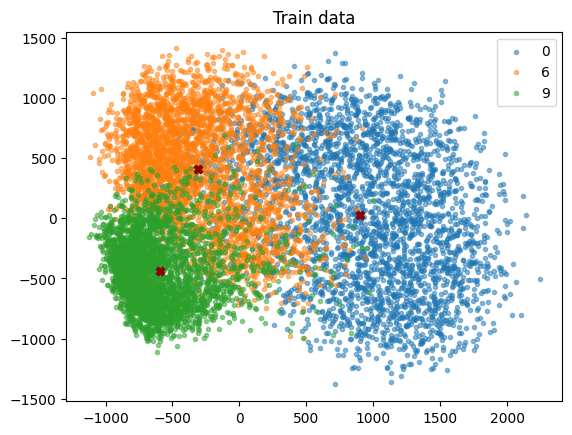

In [7]:
pca = PCA()
Z_k = pca.fit_transform(X_train, 2)

print(Z_k.shape)
plotData(Z_k, Y_train, "Train data")

In [8]:
for digit in np.unique(Y_train):
    Z_cluster = Z_k[:, Y_train == digit]
    cluster_centroid = centroid(Z_cluster)

    dists = []
    for i in range(Z_cluster.shape[1]):
        assert cluster_centroid[:, 0].shape == Z_cluster[:, i].shape
        dists.append( np.linalg.norm(cluster_centroid[:, 0] - Z_cluster[:, i], 2) )
    print(f"{digit} | train avg. distance to centroid {np.mean(dists)}")

0 | train avg. distance to centroid 725.897601240741
6 | train avg. distance to centroid 530.0432897943289
9 | train avg. distance to centroid 356.5492935671987


0 | test avg. distance to centroid 729.9429372323655
6 | test avg. distance to centroid 538.0152997811828
9 | test avg. distance to centroid 359.89452809791


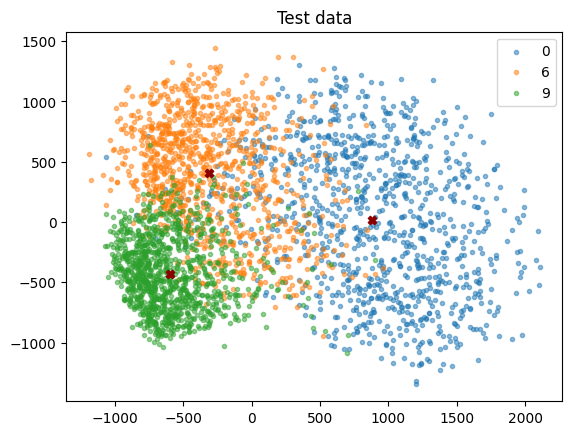

In [9]:
Z_k_test = pca.transform(X_test)

for digit in np.unique(Y_test):
    Z_cluster = Z_k_test[:, Y_test == digit]
    cluster_centroid = centroid(Z_cluster)

    dists = []
    for i in range(Z_cluster.shape[1]):
        assert cluster_centroid[:, 0].shape == Z_cluster[:, i].shape
        dists.append( np.linalg.norm(cluster_centroid[:, 0] - Z_cluster[:, i], 2) )
    print(f"{digit} | test avg. distance to centroid {np.mean(dists)}")

plotData(Z_k_test, Y_test, "Test data")

## PCA classifier

In [10]:
class MNISTClassifier:
    def __init__(self):
        self.pca = None
        self.Z_k_train = None
        self.possible_digits = None
        self.digits_centroid = None

    def fit(self, X_train, Y_train, k=2):
        self.pca = PCA()
        self.Z_k_train = self.pca.fit_transform(X_train, k)
        self.possible_digits = np.unique(Y_train)
        self.digits_centroid = { digit: centroid(self.Z_k_train[:, Y_train == digit]) for digit in self.possible_digits }
        return self
    
    def predict(self, new_digit):
        Z_k_digit = self.pca.transform(new_digit)
        best_distance = +np.inf
        best_digit = None

        for digit in self.possible_digits:
            assert self.digits_centroid[digit].shape == Z_k_digit.shape
            distance = np.linalg.norm(self.digits_centroid[digit] - Z_k_digit, 2)
            if distance < best_distance:
                best_distance = distance
                best_digit = digit

        return best_digit
    

def evaluate(model, X_test, Y_test):
    correct = 0
    total_digits = X_test.shape[1]

    for i in range(total_digits):
        prediction = model.predict(X_test[:, i])
        if prediction == Y_test[i]:
            correct += 1
    
    return correct / total_digits, correct, total_digits

In [11]:
classifier = MNISTClassifier()
classifier.fit(X_train, Y_train)

In [12]:
accuracy, correct, total_digits = evaluate(classifier, X_test, Y_test)
print(f"Accuracy: {accuracy:.5f} ({correct}/{total_digits} correct)")

Accuracy: 0.84751 (2640/3115 correct)


## Evaluation

In [13]:
def evaluateOnDigits(digits, X_full, Y_full, k=2):
    X, Y = extractDigits(X_full, Y_full, digits)
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]), random_seed=42)

    classifier = MNISTClassifier()
    classifier.fit(X_train, Y_train, k=k)
    accuracy, _, _ = evaluate(classifier, X_test, Y_test)

    return accuracy


# Prepare the triplets of digits
to_eval_digits = [*combinations(range(0, 10), 3)]

### Varying digits (k=2)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [02:09<00:00,  1.08s/it]


,digits,accuracy
2,"(0, 1, 4)",0.960273
5,"(0, 1, 7)",0.952799
94,"(3, 6, 7)",0.951598
43,"(1, 3, 4)",0.951480
60,"(1, 6, 9)",0.949585
58,"(1, 6, 7)",0.944949
7,"(0, 1, 9)",0.944940
15,"(0, 3, 4)",0.939471
96,"(3, 6, 9)",0.939098
46,"(1, 3, 7)",0.937779


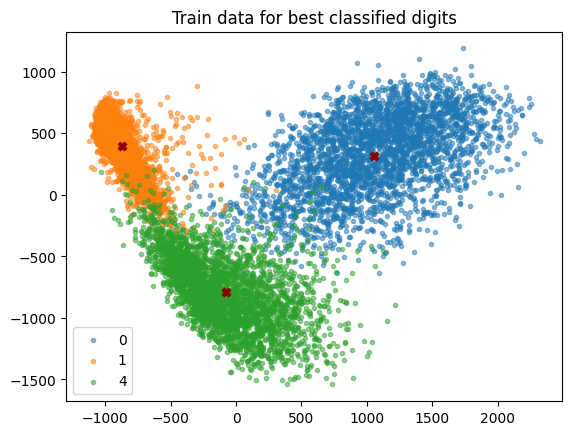

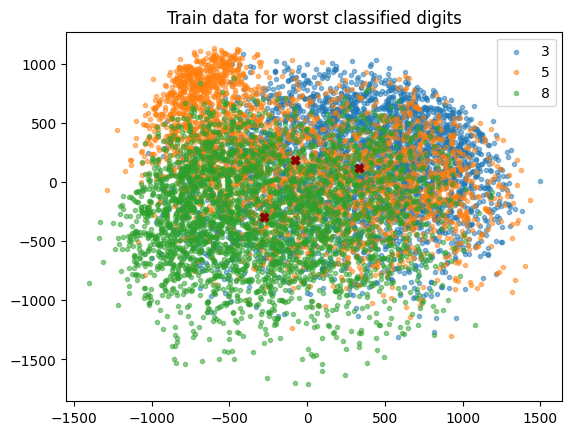

In [14]:
accuracies_df = pd.DataFrame(columns=["digits", "accuracy"])

for digits in tqdm(to_eval_digits):
    accuracy = evaluateOnDigits(digits, X_full, Y_full, k=2)
    accuracies_df.loc[len(accuracies_df)] = [digits, accuracy]

accuracies_df = accuracies_df.sort_values("accuracy", ascending=False)

pd.set_option("display.max_rows", None)
display(accuracies_df)

X, Y = extractDigits(X_full, Y_full, accuracies_df.iloc[0]["digits"])
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]), random_seed=42)
classifier = MNISTClassifier().fit(X_train, Y_train, k=2)
plotData(classifier.Z_k_train, Y_train, "Train data for best classified digits")

X, Y = extractDigits(X_full, Y_full, accuracies_df.iloc[-1]["digits"])
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]), random_seed=42)
classifier = MNISTClassifier().fit(X_train, Y_train, k=2)
plotData(classifier.Z_k_train, Y_train, "Train data for worst classified digits")

### Varying k

In [15]:
def isMonotonic(accuracies):
    return all(a <= b for a, b in zip(accuracies, accuracies[1:]))

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


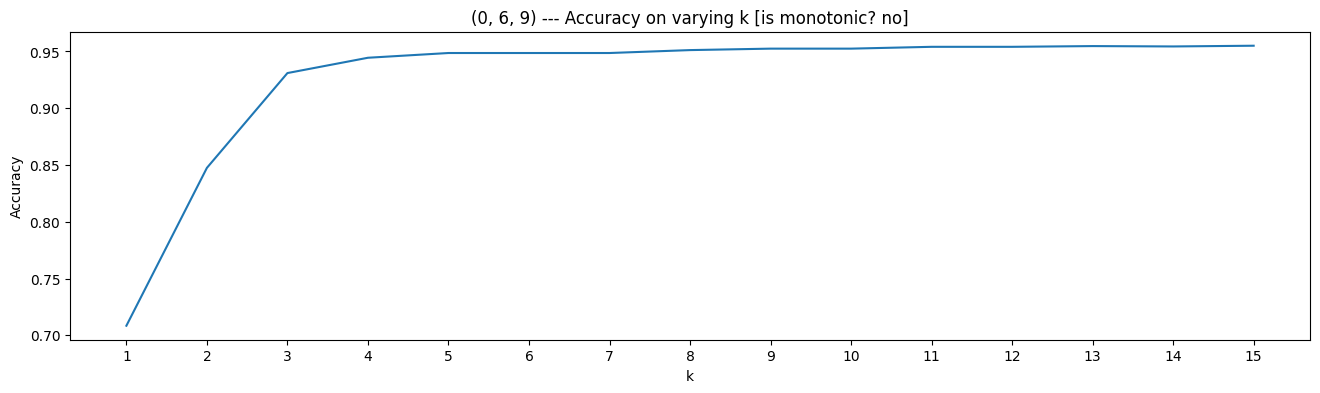

100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


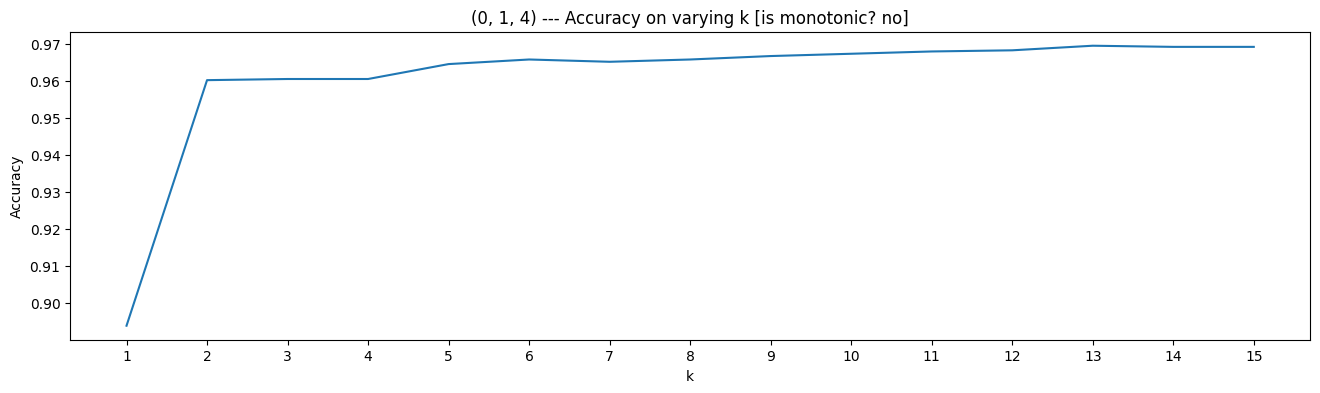

100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


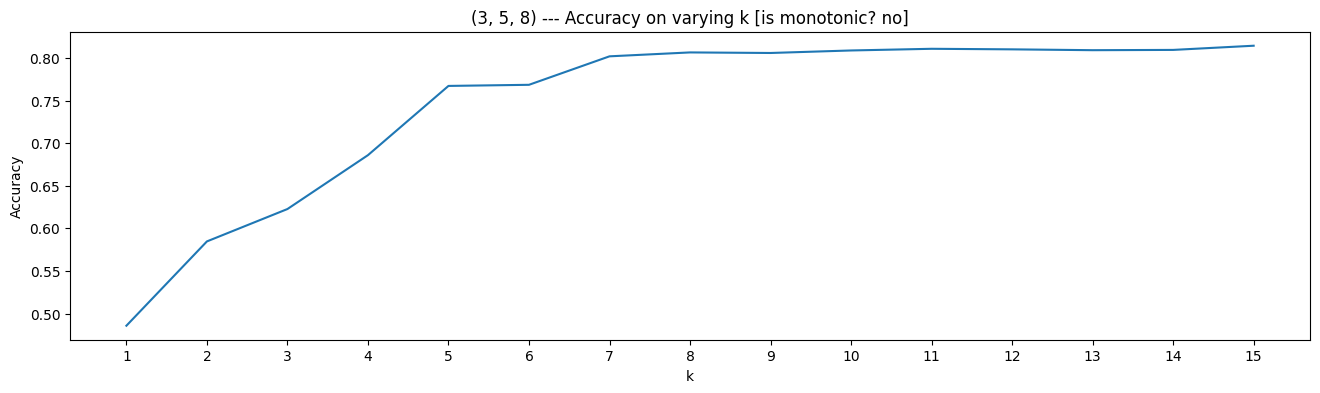

In [16]:
to_try_k = range(1, 16)
for digits in [ (0, 6, 9), accuracies_df.iloc[0]["digits"], accuracies_df.iloc[-1]["digits"] ]:
    X, Y = extractDigits(X_full, Y_full, digits)
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]), random_seed=42)
    accuracies = []
    
    for k in tqdm(to_try_k):
        classifier = MNISTClassifier()
        classifier.fit(X_train, Y_train, k=k)
        accuracy, _, _ = evaluate(classifier, X_test, Y_test)
        accuracies.append( accuracy )

    plt.figure(figsize=(16, 4))
    plt.plot(to_try_k, accuracies)
    plt.title(f"{digits} --- Accuracy on varying k [is monotonic? {'yes' if isMonotonic(accuracies) else 'no'}]")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.xticks(to_try_k)
    plt.show()

### Varying digits (k=15)

In [17]:
accuracies_df = pd.DataFrame(columns=["digits", "accuracy"])

for digits in tqdm(to_eval_digits):
    accuracy = evaluateOnDigits(digits, X_full, Y_full, k=15)
    accuracies_df.loc[len(accuracies_df)] = [digits, accuracy]

accuracies_df = accuracies_df.sort_values("accuracy", ascending=False)

pd.set_option("display.max_rows", None)
display(accuracies_df)

100%|██████████| 120/120 [02:51<00:00,  1.43s/it]


,digits,accuracy
2,"(0, 1, 4)",0.969274
5,"(0, 1, 7)",0.966717
60,"(1, 6, 9)",0.965878
43,"(1, 3, 4)",0.959719
7,"(0, 1, 9)",0.958782
104,"(4, 6, 7)",0.958135
94,"(3, 6, 7)",0.958114
23,"(0, 4, 7)",0.957805
87,"(3, 4, 7)",0.957580
15,"(0, 3, 4)",0.956993
